In [1]:
import numpy as np

import cvxpy
from scipy.optimize import minimize

from tqdm import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

$argmin_x ||x-z||^2 = argmin_x \sum_i (x_i - z_i)^2 $ and $argmin_{x\in\Delta_n} \{-z^\top x + \frac{1}{2} \|x\|_2^2\} = argmin_{x\in\Delta_n}\sum_i (z_ix_i- \frac{1}{2} x_i^2 )$ 

 Their gradients are $\nabla\|x − z\|_2^2=\langle(2x-2z),dx\rangle$ and $\nabla -z^Tx + \frac{1}{2}\|x\|_2^2=\langle(x-z),dx\rangle$ 
The minimum will be with zero. Hense:
The solutions are the same for two cases.

## Simplex projection

In [2]:
def proj_simplex(a, y):
    x = cvxpy.Variable(len(a))
    obj = cvxpy.Minimize(cvxpy.sum_squares(x - y))
    prob = cvxpy.Problem(obj, [x >= 0, a*x == 1])
    prob.solve()
    return np.array(x.value).squeeze()

In [3]:
def proj_unit(y):
    a = np.ones_like(y)
    return proj_simplex(a, y)

In [4]:
mu, sigma, N, m = 0, 1, 150, 50 # mean and standard deviation
a = [np.random.normal(loc=mu, scale=sigma, size=m) for i in range(N)]

In [5]:
def big_f(x, a_list):
    return sum([np.max([(1 - np.dot(a_list[i].T, x)), 0]) for i in range(len(a_list))]) / len(a_list)

def single_param_f(a_list):
    return lambda x: big_f(x, a_list)

In [6]:
constraints = []
constraints.append({'type': 'eq', 'fun': lambda x: x.sum() - 1, 'jac': lambda x: np.ones(m)})
constraints.append({'type': 'ineq', 'fun': lambda x: x})

x_init = np.ones(m)
f = single_param_f(a)
result = minimize(f, x_init, constraints=constraints)
f_star = result['fun']
x_star = result['x']
print(f_star)

0.8428912895245108


## SGD
$\frac{1}{N}\sum_{i=1}^N max\{1-a_i^T x, 0\} \to \displaystyle \min_{x: 1^Tx = 1, x_i \geq 0}$ 

We get:

$f(n) =$
\begin{cases}
  1 - a_i^T x & \quad 1^Tx = 1, x_i \geq 0 \\
  0
\end{cases}

$f'(n) =  $

\begin{cases}
  -a_i^T \\
  0
\end{cases}

In [7]:
x_cur = x_init

x_best = x_cur
f_best = f(x_best)

iters = 1600
vals = []
for iter_i in trange(iters):
    i = np.random.randint(0, N)
    
    dot = np.dot(a[i], x_cur)
    
    if dot >= 1 and len(vals) > 0:
        vals.append(vals[-1])
        continue
        
    grad = -a[i]
    eta = 1 / np.sqrt(m * (iter_i+1))    
    x_raw = x_cur - eta * grad
    
    x_cur = proj_unit(x_raw)
    
    val = f(x_cur)
    
    if val < f_best:
        x_best = x_cur
        f_best = val
        
    vals.append(val)
vals = np.array(vals)

100%|██████████| 1600/1600 [00:10<00:00, 151.13it/s]


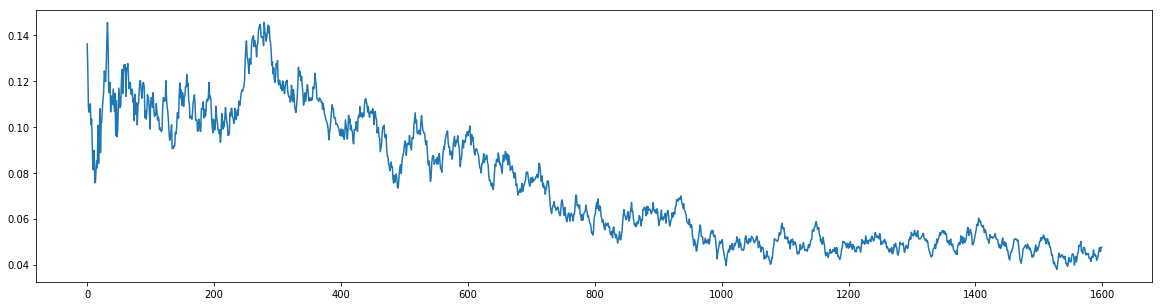

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(vals - f_star)

In [9]:
sparsity_index = (x_best < 10**(-4)).sum() / len(x_best)
print(sparsity_index)

0.3


## Dual averging

In [10]:
x_cur = x_init

x_best = x_cur
f_best = f(x_best)

iters = 1600
vals = []

theta = 0
for iter_i in trange(iters):
    i = np.random.randint(0, N)
    
    dot = np.dot(a[i], x_cur)
    
    if dot >= 1 and len(vals) > 0:
        vals.append(vals[-1])
        continue
        
    grad = -a[i]*(2/len(x_cur))*sum(x_cur)
    theta += grad
    eta = 1 /(iter_i+1)
    
    x_raw = np.dot(theta, x_cur) + eta * grad
    
    x_cur = proj_unit(x_raw)
    
    val = f(x_cur)
    
    if val < f_best:
        x_best = x_cur
        f_best = val
        
    vals.append(val)
vals = np.array(vals)

100%|██████████| 1600/1600 [00:10<00:00, 148.18it/s]


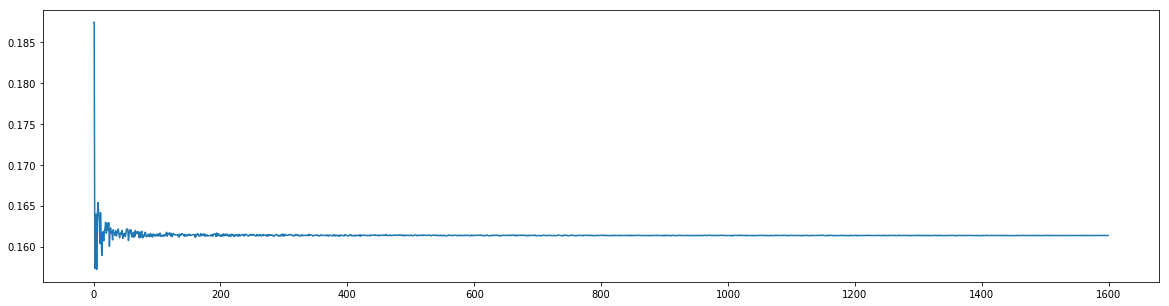

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(vals - f_star)

In [12]:
sparsity_index = (x_best < 10**(-4)).sum() / len(x_best)
print(sparsity_index)

0.02
